In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


In [2]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

# For multilayer perceptron
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
print("Tensorflow v" + tf.__version__)
print("Tensorflow Decision Forests v" + tfdf.__version__)

Tensorflow v2.12.0
Tensorflow Decision Forests v1.3.0


## Load the Dataset

In [4]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (617, 58)


In [5]:
dataset_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


## Quick basic dataset exploration

In [6]:
dataset_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


## Pie chart for label column: Class

<Axes: ylabel='Class'>

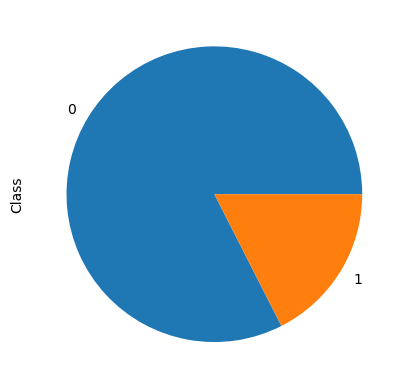

In [7]:
plot_df = dataset_df.Class.value_counts()
plot_df.plot(kind="pie")

## Numerical data distribution

In [8]:
# Store all the numerical column names into a list
NUM_FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id", "EJ", "Class"]]

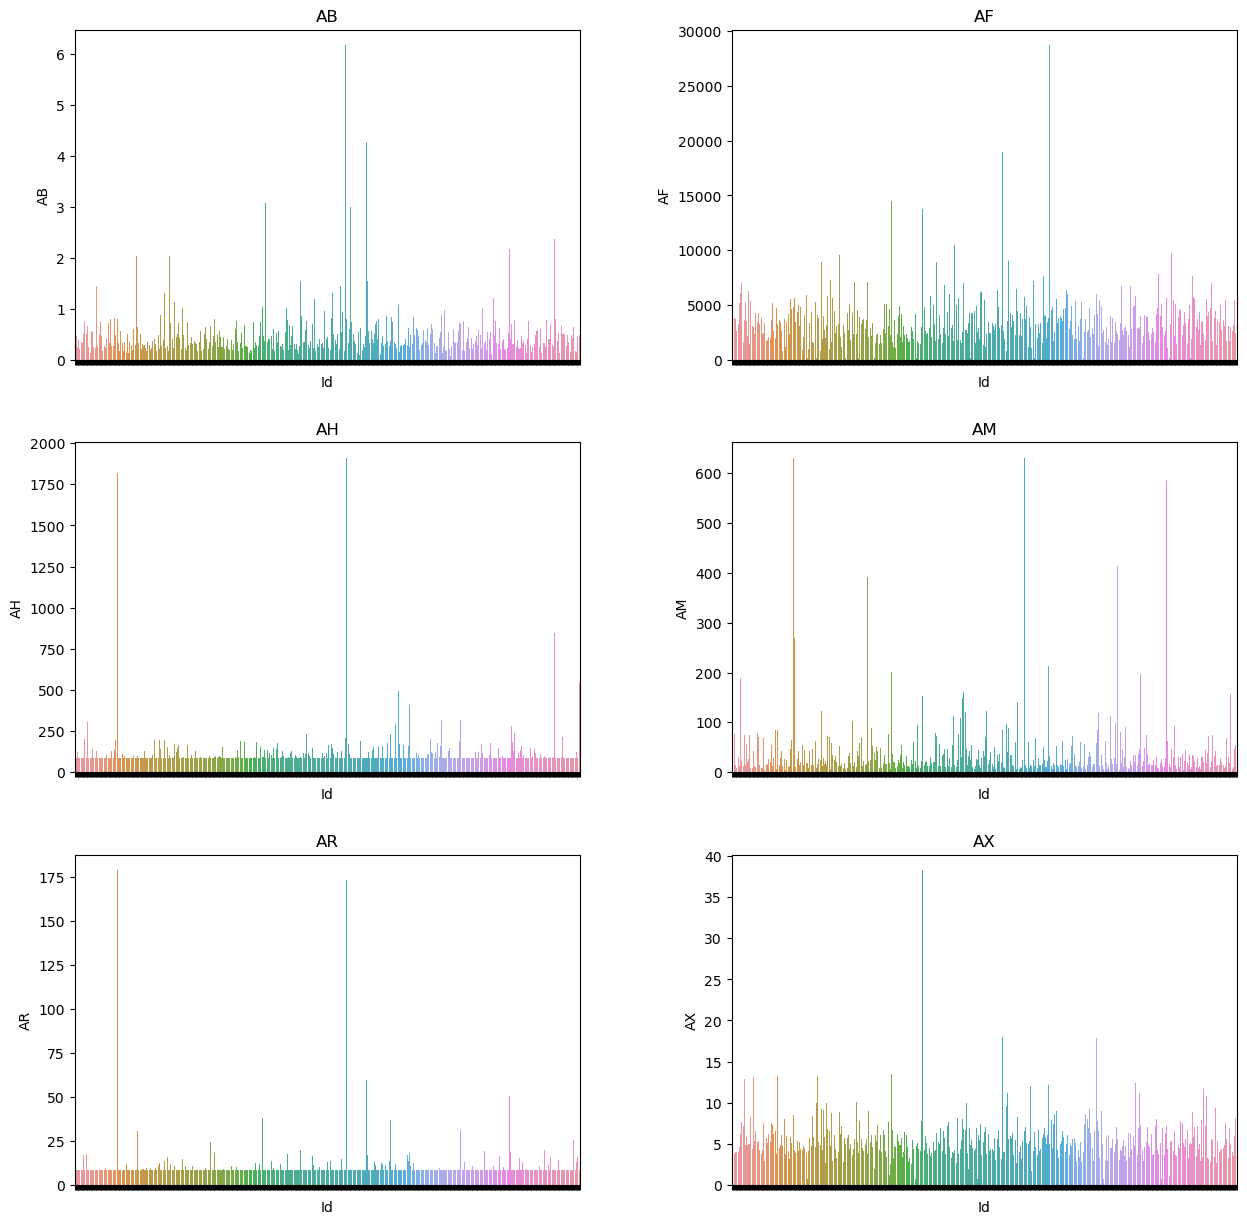

In [9]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(NUM_FEATURE_COLUMNS[:6]):
    row = i//2
    col = i % 2
    bp = sns.barplot(ax=axis[row, col], x=dataset_df['Id'], y=dataset_df[column_name])
    bp.set(xticklabels=[])
    axis[row, col].set_title(column_name)
plt.show()

In [10]:
FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id"]]

## KFold validation

In [11]:
# Creates a GroupKFold with 5 splits
kf = KFold(n_splits=5)

## Out of Fold (OOF)

In [12]:
# Create list of ids for the creation of oof dataframe
ID_LIST = dataset_df.index

# Create a dataframe of required size with zero values.
oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metrics for the models trained for each fold.
accuracy = {}
cross_entropy = {}

# Save the name of the label column to a variable.
label = "Class"

## Select a Model

In [13]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

## Strategies to handle the dataset imbalance

In [14]:
# Calculate the number of negative and positive values in `Class` column
neg, pos = np.bincount(dataset_df['Class'])
# Calculate total samples
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 617
    Positive: 108 (17.50% of total)



## Class weighting

In [15]:
# Calculate the number of samples for each label.
neg, pos = np.bincount(dataset_df['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.86


In [16]:
# Loop through each fold
for i, (train_index, valid_index) in enumerate(kf.split(X=dataset_df)):
    print('##### Fold',i+1)
    
    # Fetch values corresponding to the index
    train_df = dataset_df.iloc[train_index]
    valid_df = dataset_df.iloc[valid_index]
    valid_ids = valid_df.index.values
    
    # Select only feature columns for training.
    train_df = train_df[FEATURE_COLUMNS]
    valid_df = valid_df[FEATURE_COLUMNS]
    
    # There's one more step required before we can train the model.
    # We need to convert the dataset from Pandas format (pd.DataFrame)
    # into Tensorflow Datasets format (tf.data.Dataset).
    # Tensorflow Datasets is a high performance data loading library
    # which is helpful when training neural networks with accelerators like GPUs and TPUs.
    # Note: Some column names contains white spaces at the end of their name,
    # which is non-compatible with SavedModels save format.
    # By default, `pd_dataframe_to_tf_dataset` function will convert
    # this column names into a compatible format.
    # So you can safely ignore the warnings related to this.
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)
    
    # Define the model and metrics
    rf = tfdf.keras.RandomForestModel()
    rf.compile(metrics=["accuracy", "binary_crossentropy"])
    
    # Train the model
    rf.fit(x=train_ds, class_weight=class_weight)
    
    # Store the model
    models[f"fold_{i+1}"] = rf
    
    # Predict OOF value for validation data
    predict = rf.predict(x=valid_ds)
    
    # Store the predictions in oof dataframe
    oof.loc[valid_ids, 0] = predict.flatten()
    
    # Evaluate and store the metrics in respective dicts
    evaluation = rf.evaluate(x=valid_ds,return_dict=True)
    accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
    cross_entropy[f"fold_{i+1}"] = evaluation["binary_crossentropy"]

##### Fold 1
Use /tmp/tmpf72sh2ts as temporary training directory
Reading training dataset...
Training dataset read in 0:00:08.123692. Found 493 examples.
Training model...
Model trained in 0:00:00.328600
Compiling model...


[INFO 23-06-23 01:08:08.0624 UTC kernel.cc:1242] Loading model from path /tmp/tmpf72sh2ts/model/ with prefix 2de4861d229646b0
[INFO 23-06-23 01:08:08.1229 UTC decision_forest.cc:660] Model loaded with 300 root(s), 14268 node(s), and 56 input feature(s).
[INFO 23-06-23 01:08:08.1231 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 01:08:08.1233 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 1s 787ms/step - loss: 0.0000e+00 - accuracy: 0.9516 - binary_crossentropy: 0.2182
##### Fold 2
Use /tmp/tmpb5zbp99r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.110024. Found 493 examples.
Training model...
Model trained in 0:00:00.268750
Compiling model...


[INFO 23-06-23 01:08:13.8200 UTC kernel.cc:1242] Loading model from path /tmp/tmpb5zbp99r/model/ with prefix 76f100424ea342d7
[INFO 23-06-23 01:08:13.8752 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13582 node(s), and 56 input feature(s).
[INFO 23-06-23 01:08:13.8755 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 388ms/step - loss: 0.0000e+00 - accuracy: 0.8790 - binary_crossentropy: 0.2608
##### Fold 3
Use /tmp/tmpcg9j_t0s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.095470. Found 494 examples.
Training model...
Model trained in 0:00:00.262376
Compiling model...


[INFO 23-06-23 01:08:16.8918 UTC kernel.cc:1242] Loading model from path /tmp/tmpcg9j_t0s/model/ with prefix 12e92beec77a457c
[INFO 23-06-23 01:08:16.9466 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13376 node(s), and 56 input feature(s).
[INFO 23-06-23 01:08:16.9467 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 401ms/step - loss: 0.0000e+00 - accuracy: 0.9024 - binary_crossentropy: 0.2741
##### Fold 4
Use /tmp/tmp6xm7_w83 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.090683. Found 494 examples.
Training model...
Model trained in 0:00:00.265389
Compiling model...


[INFO 23-06-23 01:08:19.5723 UTC kernel.cc:1242] Loading model from path /tmp/tmp6xm7_w83/model/ with prefix ef7741335ff9497f
[INFO 23-06-23 01:08:19.6265 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13434 node(s), and 56 input feature(s).
[INFO 23-06-23 01:08:19.6266 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-23 01:08:19.6266 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 388ms/step - loss: 0.0000e+00 - accuracy: 0.9024 - binary_crossentropy: 0.2717
##### Fold 5
Use /tmp/tmpo78r208y as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.102949. Found 494 examples.
Training model...
Model trained in 0:00:00.308662
Compiling model...


[INFO 23-06-23 01:08:22.9847 UTC kernel.cc:1242] Loading model from path /tmp/tmpo78r208y/model/ with prefix d5d81f44a75d43ce
[INFO 23-06-23 01:08:23.0418 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13980 node(s), and 56 input feature(s).
[INFO 23-06-23 01:08:23.0418 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 393ms/step - loss: 0.0000e+00 - accuracy: 0.9512 - binary_crossentropy: 0.2172


## Visualize the model

In [17]:
tfdf.model_plotter.plot_model_in_colab(models['fold_1'], tree_idx=0, max_depth=3)

## Evaluate the model on the Out of bag (OOB) data and the validation dataset

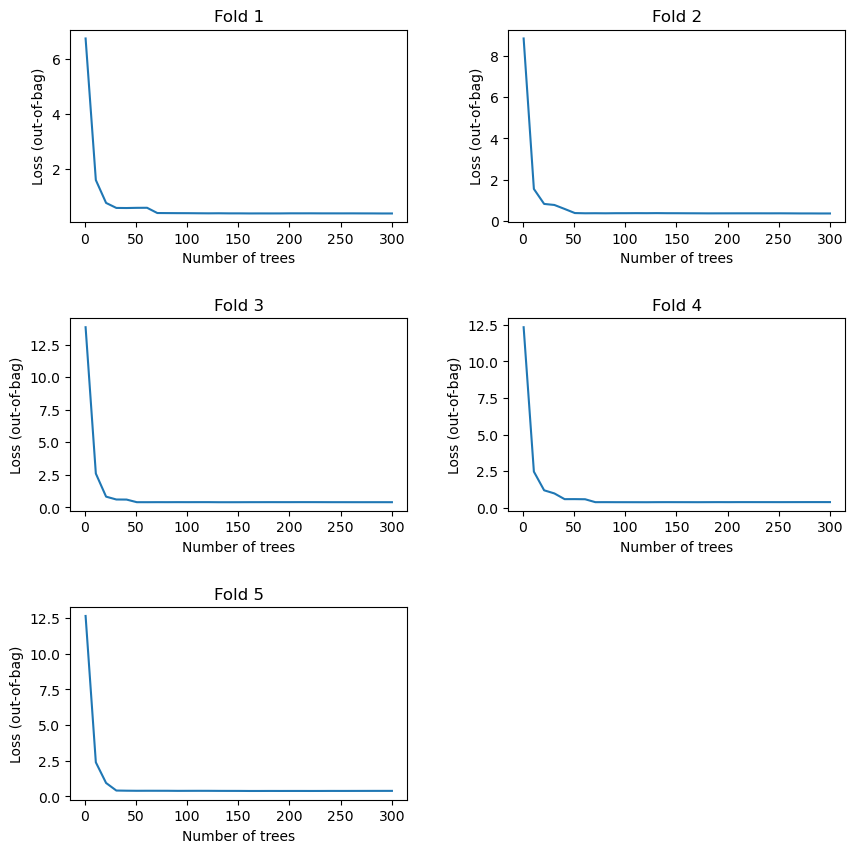

In [18]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, fold_no in enumerate(models.keys()):
    row = i//2
    col = i % 2
    logs = models[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Loss (out-of-bag)')
    
axis[2][1].set_visible(False)
plt.show()

In [19]:
for _model in models:
    inspector = models[_model].make_inspector()
    print(_model, inspector.evaluation())

fold_1 Evaluation(num_examples=493, accuracy=0.83384120423487, loss=0.4011864148867133, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_2 Evaluation(num_examples=493, accuracy=0.86791143186256, loss=0.374230902610848, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_3 Evaluation(num_examples=494, accuracy=0.8625237360976467, loss=0.39912028399338717, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_4 Evaluation(num_examples=494, accuracy=0.8742180068903357, loss=0.38689070260817593, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_5 Evaluation(num_examples=494, accuracy=0.8477430594687857, loss=0.39049966583287166, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)


In [20]:
average_loss = 0
average_acc = 0

for _model in models:
    average_loss += cross_entropy[_model]
    average_acc += accuracy[_model]
    print(f"{_model}: acc: {accuracy[_model]:.4f} loss: {cross_entropy[_model]:.4f}")
    
print(f"\nAverage accuracy: {average_acc/5:.4f} Average loss: {average_loss/5:.4f}")

fold_1: acc: 0.9516 loss: 0.2182
fold_2: acc: 0.8790 loss: 0.2608
fold_3: acc: 0.9024 loss: 0.2741
fold_4: acc: 0.9024 loss: 0.2717
fold_5: acc: 0.9512 loss: 0.2172

Average accuracy: 0.9173 Average loss: 0.2484


## Variable importances

In [21]:
inspector = models['fold_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
    print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES
	 INV_MEAN_MIN_DEPTH


In [22]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("DU" (1; #32), 47.0),
 ("DI" (1; #29), 25.0),
 ("DA" (1; #25), 21.0),
 ("AB" (1; #0), 19.0),
 ("FL" (1; #47), 19.0),
 ("GL" (1; #55), 18.0),
 ("BQ" (1; #12), 16.0),
 ("CR" (1; #21), 16.0),
 ("FD_" (1; #44), 16.0),
 ("CD_" (1; #17), 14.0),
 ("AF" (1; #1), 13.0),
 ("CC" (1; #16), 8.0),
 ("DF" (1; #27), 7.0),
 ("AR" (1; #4), 6.0),
 ("DH" (1; #28), 6.0),
 ("EB" (1; #35), 6.0),
 ("FI" (1; #46), 6.0),
 ("BC" (1; #8), 5.0),
 ("EH" (1; #38), 5.0),
 ("FR" (1; #48), 5.0),
 ("DE" (1; #26), 4.0),
 ("DL" (1; #30), 4.0),
 ("EE" (1; #36), 4.0),
 ("FE" (1; #45), 4.0),
 ("EU" (1; #42), 3.0),
 ("BN" (1; #10), 2.0),
 ("EL" (1; #40), 1.0)]

## Multilayer perceptron

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.9252 - binary_accuracy: 0.4870 - val_loss: 0.7824 - val_binary_accuracy: 0.8387
Epoch 2/200
1/1 [==============================] - 0s 53ms/step - loss: 0.7835 - binary_accuracy: 0.5714 - val_loss: 0.5419 - val_binary_accuracy: 0.8129
Epoch 3/200
1/1 [==============================] - 0s 57ms/step - loss: 0.6845 - binary_accuracy: 0.6277 - val_loss: 0.5854 - val_binary_accuracy: 0.7742
Epoch 4/200
1/1 [==============================] - 0s 50ms/step - loss: 0.6509 - binary_accuracy: 0.6753 - val_loss: 0.8018 - val_binary_accuracy: 0.6194
Epoch 5/200
1/1 [==============================] - 0s 51ms/step - loss: 0.5739 - binary_accuracy: 0.7229 - val_loss: 1.1099 - val_binary_accuracy: 0.4645
Epoch 6/200
1/1 [==============================] - 0s 51ms/step - loss: 0.5315 - binary_accuracy: 0.7381 - val_loss: 1.4085 - val_binary_accuracy: 0.2839
Epoch 7/200
1/1 [==============================] - 0s 66ms/step - loss: 0.4963

<Axes: title={'center': 'Accuracy'}>

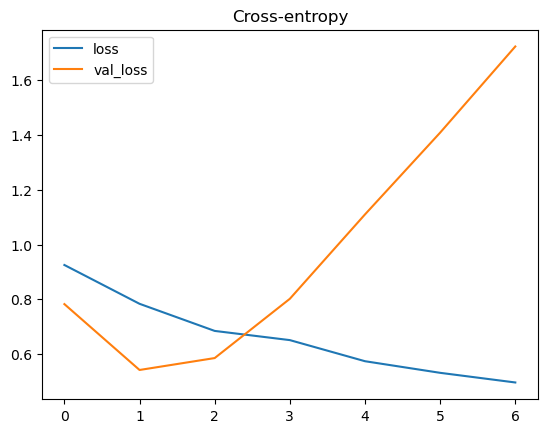

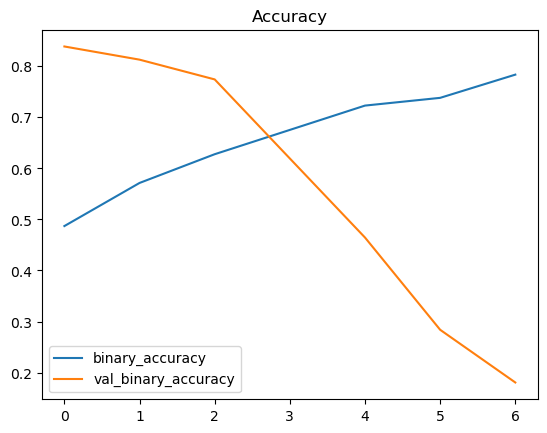

In [23]:
test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')

# Select only feature columns for training.
# Maybe I should convert X and y to specific data type for tensorflow.
X = dataset_df[NUM_FEATURE_COLUMNS]
y = dataset_df[label]

# It is important to treat nulls.
ISNA_COLUMNS_TRAIN = dataset_df.columns[dataset_df.isna().any()].to_list()
X = X.drop(columns=ISNA_COLUMNS_TRAIN)

# In case test data have nulls, drop the columns from training data.
ISNA_COLUMNS_TEST = test_df.columns[test_df.isna().any()].to_list()
X = X.drop(columns=ISNA_COLUMNS_TEST)

# I should check what stratify do.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.75)

mlp = tf.keras.Sequential([
    layers.BatchNormalization(input_shape=[X.shape[1]]),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# I need to review metrics later.
mlp.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

# I need to review batch_size and epochs depending on the size of training data.
# The model needs to train with small batch size
history = mlp.fit(
    X_train, y_train, validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

## Submission

In [24]:
# test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
test_ds_pd = test_df
test_df_columns = test_ds_pd.columns.to_list()
TEST_FEATURE_COLUMNS = [i for i in FEATURE_COLUMNS if i in test_df_columns and i != "Class"]
test_ds_pd = test_ds_pd[TEST_FEATURE_COLUMNS]
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd)
predictions = models['fold_1'].predict(test_ds)
n_predictions = [[round(abs(i-1), 8), i] for i in predictions.ravel()]
print(n_predictions)

1/1 [==============================] - 0s 140ms/step
[[0.65333357, 0.34666643], [0.65333357, 0.34666643], [0.65333357, 0.34666643], [0.65333357, 0.34666643], [0.65333357, 0.34666643]]


In [25]:
sample_submission = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
sample_submission[['class_0', 'class_1']] = n_predictions
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)

## Submission - Multilayer perceptron

In [26]:
mlp_test_ds_pd = test_df
MLP_TEST_FEATURE_COLUMNS = [i for i in NUM_FEATURE_COLUMNS if i not in ISNA_COLUMNS_TRAIN and i not in ISNA_COLUMNS_TEST]
mlp_test_ds_pd = mlp_test_ds_pd[MLP_TEST_FEATURE_COLUMNS]
mlp_predictions = mlp.predict(mlp_test_ds_pd)
mlp_n_predictions = [[round(abs(i-1), 8), i] for i in mlp_predictions.ravel()]
print(mlp_n_predictions)

1/1 [==============================] - 0s 160ms/step
[[0.51664361, 0.4833564], [0.51664361, 0.4833564], [0.51664361, 0.4833564], [0.51664361, 0.4833564], [0.51664361, 0.4833564]]


In [27]:
mlp_submission = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
mlp_submission[['class_0', 'class_1']] = mlp_n_predictions
mlp_submission.to_csv('/kaggle/working/submission.csv', index=False)